# Demo parameter sweeps of channel measurements
This demonstrates the construction of larger datasets built by looping across measurements of different channels.

In [1]:
from channel_analysis import waveform
from channel_analysis.sources import simulated_awgn
import xarray as xr

source = waveform.WaveformSource(sample_rate=15.36e6, analysis_bandwidth=10e6)

analysis_spec = {
    'power_time_series': {
        'detector_period': 10e-3,
        'detectors': ('rms', 'peak')
    },
    'cyclic_channel_power': {
        'cyclic_period': 10e-3,
        'detector_period': 1e-3 / 15 / 4,
        'detectors': ('rms', 'peak'),
        'cyclic_statistics': ('min', 'mean', 'max'),
    },
    'persistence_spectrum': {
        'window': 'hamming',
        'fractional_overlap': 0.5,
        'resolution': 15e3,
        'quantiles': [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1],
    },
    'amplitude_probability_distribution': {
        'power_low': -40,
        'power_high': 15,
        'power_count': 221,  # 0.25 dB resolution
    },
    'iq_waveform': {
        'start_time_sec': 0,
        'stop_time_sec': 100e-3
    }
}

filter_spec = {
    'fft_size': 1024,
    'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
}

acquisition_spec = {
    'duration': 0.2,
    'sample_rate': source.sample_rate
}

### Single acquisition

In [59]:
from __future__ import annotations
import msgspec
from typing import Literal, Optional
from channel_analysis import waveform
from pathlib import Path

class State(msgspec.Struct):
    # RF and leveling
    center_frequency: float = 3710e6
    channel: int = 0
    gain: float = -10
    calibrated: bool = True

    # acquisition
    duration: float = 0.1
    sample_rate: float = 15.36e6

    # filtering and resampling
    analysis_bandwidth: float = 10e6
    if_frequency: Optional[float] = None # Hz (or none, for no IF frontend)
    lo_shift: Optional['left'|'right'] = 'left' # shift the LO outside the acquisition band
    window: 'hamming'|'blackman'|'blackmanharris' = 'hamming' # the COLA spectral window to use


class Acquisition(msgspec.Struct):
    location: Optional[tuple[str,str,str]] = None
    timebase: Literal['builtin']|Literal['gps'] = 'builtin'
    cyclic_trigger: bool|float = False
    calibration_path: Optional[str] = None
    defaults: State = msgspec.field(default_factory=State)

class Runner(msgspec.Struct):
    acquisition: Acquisition = msgspec.field(default_factory=Acquisition)
    sweep: list[State] = msgspec.field(default_factory=lambda: [State()])
    channel_analysis: waveform._ConfigStruct = \
        msgspec.field(default_factory=lambda: waveform._registry.tospec()())

runner = Runner()
runner.acquisition.calibration_path

In [60]:
print(msgspec.yaml.encode(runner).decode())

acquisition:
  location: null
  timebase: builtin
  cyclic_trigger: false
  calibration_path: null
  defaults: {}
sweep:
- {}
channel_analysis:
  power_time_series: null
  cyclic_channel_power: null
  amplitude_probability_distribution: null
  persistence_spectrum: null
  iq_waveform: null



In [2]:
from edge_sensor import dataset

iq = simulated_awgn(source, duration=0.1)

dataset.from_spec(
    iq,
    source,
    analysis_spec=analysis_spec,
)

<xarray.Dataset> Size: 25MB
Dimensions:                             (power_detector: 2, time_elapsed: 10,
                                         cyclic_statistic: 3, cyclic_lag: 600,
                                         channel_power: 221,
                                         iq_sample: 1536000,
                                         persistence_statistic: 9,
                                         baseband_frequency: 667,
                                         temperature_sensor: 0,
                                         compute_status_category: 3)
Coordinates:
  * power_detector                      (power_detector) <U4 32B 'rms' 'peak'
  * time_elapsed                        (time_elapsed) float64 80B 0.0 ... 0.09
  * cyclic_statistic                    (cyclic_statistic) <U4 48B 'min' ... ...
  * cyclic_lag                          (cyclic_lag) float64 5kB 0.0 ... 0.00...
  * channel_power                       (channel_power) float32 884B -40.0 .....
  * iq_sample                           (iq_sample) int64 12MB 0 1 ... 1535999
  * persistence_statistic               (persistence_statistic) <U5 180B '0.1...
  * baseband_frequency                  (baseband_frequency) float64 5kB -4.9...
  * temperature_sensor                  (temperature_sensor) float64 0B 
  * compute_status_category             (compute_status_category) <U21 252B '...
Data variables:
    power_time_series                   (power_detector, time_elapsed) float32 80B ...
    cyclic_channel_power                (power_detector, cyclic_statistic, cyclic_lag) float32 14kB ...
    amplitude_probability_distribution  (channel_power) float32 884B 0.9999 ....
    iq_waveform                         (iq_sample) complex64 12MB (-1.101895...
    persistence_spectrum                (persistence_statistic, baseband_frequency) float32 24kB ...
    temperature                         (temperature_sensor) float64 0B 
    compute_status                      (compute_status_category) float64 24B ...
Attributes:
    sample_rate:         15360000.0
    analysis_bandwidth:  10000000.0
    analysis_filter:     {'fft_size': 1024, 'window': 'hamming'}

## RF parameter sweep
### Single parameter

In [3]:
data = []

for fc in [3705e6, 3715e6, 3725e6]:
    iq = simulated_awgn(source, duration=0.1)

    ret = dataset.from_spec(
        iq,
        source,
        analysis_spec=analysis_spec,
    )

    data.append(ret.assign_coords({'center_frequency': [fc]}))

data = xr.combine_by_coords(data)
data

<xarray.Dataset> Size: 49MB
Dimensions:                             (power_detector: 2, time_elapsed: 10,
                                         center_frequency: 3,
                                         cyclic_statistic: 3, cyclic_lag: 600,
                                         channel_power: 221,
                                         iq_sample: 1536000,
                                         persistence_statistic: 9,
                                         baseband_frequency: 667,
                                         temperature_sensor: 0,
                                         compute_status_category: 3)
Coordinates:
  * power_detector                      (power_detector) <U4 32B 'rms' 'peak'
  * time_elapsed                        (time_elapsed) float64 80B 0.0 ... 0.09
  * cyclic_statistic                    (cyclic_statistic) <U4 48B 'min' ... ...
  * cyclic_lag                          (cyclic_lag) float64 5kB 0.0 ... 0.00...
  * channel_power                       (channel_power) float32 884B -40.0 .....
  * iq_sample                           (iq_sample) int64 12MB 0 1 ... 1535999
  * persistence_statistic               (persistence_statistic) <U5 180B '0.1...
  * baseband_frequency                  (baseband_frequency) float64 5kB -4.9...
  * temperature_sensor                  (temperature_sensor) float64 0B 
  * compute_status_category             (compute_status_category) <U21 252B '...
  * center_frequency                    (center_frequency) float64 24B 3.705e...
Data variables:
    power_time_series                   (center_frequency, power_detector, time_elapsed) float32 240B ...
    cyclic_channel_power                (center_frequency, power_detector, cyclic_statistic, cyclic_lag) float32 43kB ...
    amplitude_probability_distribution  (center_frequency, channel_power) float32 3kB ...
    iq_waveform                         (center_frequency, iq_sample) complex64 37MB ...
    persistence_spectrum                (center_frequency, persistence_statistic, baseband_frequency) float32 72kB ...
    temperature                         (center_frequency, temperature_sensor) float64 0B ...
    compute_status                      (center_frequency, compute_status_category) float64 72B ...
Attributes:
    sample_rate:         15360000.0
    analysis_bandwidth:  10000000.0
    analysis_filter:     {'fft_size': 1024, 'window': 'hamming'}

In [4]:
data = []

for atten in [0.0, 10.0]:
    for fc in [3705e6, 3715e6, 3725e6]:
        iq = simulated_awgn(source, duration=0.1)

        ret = (
            dataset.from_spec(
                    iq,
                    source,
                    analysis_spec=analysis_spec,
            ).assign_coords(
                {'center_frequency': [fc], 'attenuation': [atten]}
            )
        )

        data.append(ret)

ds = xr.combine_by_coords(data)
ds.center_frequency.attrs = {'label': 'RF center frequency', 'units': 'Hz'}
ds.attenuation.attrs = {'label': 'External attenuation setting', 'units': 'dB'}

In [5]:
(
    ds
    .chunk({'iq_sample': round(source.sample_rate*10e-3)})
    .to_zarr('dataset.zarr', mode='w')
)

ds

<xarray.Dataset> Size: 86MB
Dimensions:                             (power_detector: 2, time_elapsed: 10,
                                         attenuation: 2, center_frequency: 3,
                                         cyclic_statistic: 3, cyclic_lag: 600,
                                         channel_power: 221,
                                         iq_sample: 1536000,
                                         persistence_statistic: 9,
                                         baseband_frequency: 667,
                                         temperature_sensor: 0,
                                         compute_status_category: 3)
Coordinates:
  * power_detector                      (power_detector) <U4 32B 'rms' 'peak'
  * time_elapsed                        (time_elapsed) float64 80B 0.0 ... 0.09
  * cyclic_statistic                    (cyclic_statistic) <U4 48B 'min' ... ...
  * cyclic_lag                          (cyclic_lag) float64 5kB 0.0 ... 0.00...
  * channel_power                       (channel_power) float32 884B -40.0 .....
  * iq_sample                           (iq_sample) int64 12MB 0 1 ... 1535999
  * persistence_statistic               (persistence_statistic) <U5 180B '0.1...
  * baseband_frequency                  (baseband_frequency) float64 5kB -4.9...
  * temperature_sensor                  (temperature_sensor) float64 0B 
  * compute_status_category             (compute_status_category) <U21 252B '...
  * center_frequency                    (center_frequency) float64 24B 3.705e...
  * attenuation                         (attenuation) float64 16B 0.0 10.0
Data variables:
    power_time_series                   (attenuation, center_frequency, power_detector, time_elapsed) float32 480B ...
    cyclic_channel_power                (attenuation, center_frequency, power_detector, cyclic_statistic, cyclic_lag) float32 86kB ...
    amplitude_probability_distribution  (attenuation, center_frequency, channel_power) float32 5kB ...
    iq_waveform                         (attenuation, center_frequency, iq_sample) complex64 74MB ...
    persistence_spectrum                (attenuation, center_frequency, persistence_statistic, baseband_frequency) float32 144kB ...
    temperature                         (attenuation, center_frequency, temperature_sensor) float64 0B ...
    compute_status                      (attenuation, center_frequency, compute_status_category) float64 144B ...
Attributes:
    sample_rate:         15360000.0
    analysis_bandwidth:  10000000.0
    analysis_filter:     {'fft_size': 1024, 'window': 'hamming'}

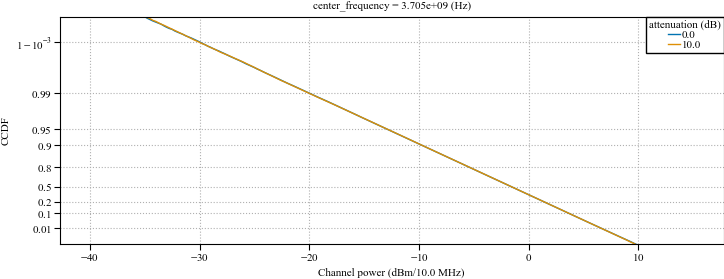

In [6]:
from channel_analysis import figures
import matplotlib.pyplot as plt
import iqwaveform # needed for the ieee double column style
plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()
apd = ds.amplitude_probability_distribution.sel(center_frequency=3705e6)
apd.plot.line(x='channel_power', ax=ax)
ax.set_yscale('gamma-qq', k=1, db_ordinal=True)
figures.label_axis(ax.xaxis, apd, 'channel_power', tick_units=False)
figures.label_axis(ax.yaxis, apd)

In [7]:
from pathlib import Path

def directory_size(path):
    path = Path(path)
    if path.is_file():
        return path.stat().st_size
    
    children = Path(path).glob('**/*')
    return sum([p.stat().st_size for p in children if p.is_file()])

# assume we will want to read 10 ms at a time for performance reasons
path = 'xarray-sweep.zarr'

# orient the data under the assumption that we want to load 1 frame at a time
chunks = {'iq_sample': round(source.sample_rate*10e-3)}

%timeit -n1 -r1 ds.sel(attenuation=0,center_frequency=3705e6).chunk(chunks).to_zarr(path, mode='w')

print(f'data size: {directory_size(path)/1e6:0.1f} MB')

93.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
data size: 11.4 MB


In [8]:
from channel_analysis import waveform

import typing

import msgspec
import inspect

class ChannelAnalysisSpec(msgspec.Struct):
    pass

def _msgspec_param(name, parameter):
    if parameter.annotation is inspect._empty:
        type_ = typing.Any
    else:
        type_ = parameter.annotation

    if parameter.default is inspect._empty:
        return (name, type_)
    else:
        return (name, type_, parameter.default)

def _struct_from_func(func) -> msgspec.Struct:
    name = func.__name__

    params = inspect.signature(func).parameters

    globals()['params'] = params

    kws = [
        _msgspec_param(k, p)
        for k, p in list(params.items())
        if p.kind is inspect.Parameter.KEYWORD_ONLY
    ]

    struct = msgspec.defstruct(
        name,
        kws,
        bases=(ChannelAnalysisSpec,)
    )

    return struct

Struct = _struct_from_func(waveform.persistence_spectrum)
s = Struct(quantiles=[1,2,3], resolution=15e3, window='flattop')
msgspec.to_builtins(s)

{'window': 'flattop',
 'resolution': 15000.0,
 'quantiles': [1, 2, 3],
 'fractional_overlap': 0,
 'truncate': True,
 'dB': True}

In [9]:
spec_struct = waveform._registry.tospec()

import yaml
raw = yaml.load(open('run.yaml', 'r'), yaml.SafeLoader)
chan_yaml = yaml.dump(raw['channel_analyses'])

d = msgspec.to_builtins(msgspec.yaml.decode(chan_yaml, type=spec_struct))

In [10]:
spec_struct(d)

channel_analyses(power_time_series={'power_time_series': {'detector_period': 0.01, 'detectors': ('rms', 'peak')}, 'cyclic_channel_power': {'cyclic_period': 0.01, 'detector_period': 1.6666666666666667e-05, 'detectors': ('rms', 'peak'), 'cyclic_statistics': ('min', 'mean', 'max')}, 'amplitude_probability_distribution': {'power_low': -40.0, 'power_high': 15.0, 'power_count': 221.0}, 'persistence_spectrum': {'window': ['dpss', 5], 'resolution': 15000.0, 'quantiles': (0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1.0), 'fractional_overlap': 0, 'truncate': True, 'dB': True}, 'iq_waveform': {'start_time_sec': 0.0, 'stop_time_sec': 0.1}}, cyclic_channel_power=None, amplitude_probability_distribution=None, persistence_spectrum=None, iq_waveform=None)